In [1]:
from igraph import *
import cairo
import numpy as np
import pandas as pd
import numpy as np

### Get 1-net for graph

In [9]:
class GraphWrapper:
    def __init__(self, graph_df=None, test_mode=None, n=10, radius=0.5):
        self.test_mode = test_mode
        
        # random graph
        if graph_df is None:
            #g = Graph.GRG(n, radius)
            g = Graph.K_Regular(n=10, k=4, directed=True)
            #g = Graph.Full(n=10, directed=True)
            g.vs["color"] = "green"

            for ind, val in enumerate(g.vs):
                g.vs[ind]["label"] = ind

            self.graph = g
            self.data = graph_df
            
        # out of pandas dataframe
        else:
            g = Graph(directed=True)
            g.add_vertices(pd.unique(graph_df.values.ravel('K')))
            g.add_edges(list(graph_df.itertuples(index=False, name=None)))

            for ind, val in enumerate(g.vs):
                g.vs[ind]["label"] = ind
            
            self.graph = g
            self.data = graph_df
    
    def _simple_net(self):
        if not self.derived:
            self.derived = self.graph
        
        result_graph = Graph()         
        adjlist = self.derived.get_adjlist()

        for ind, node in enumerate(self.derived.vs):
            # get adjacent vertices for node
            adj_vertices = list(map(lambda adj_index: self.derived.vs[adj_index], adjlist[ind]))
            adj_vertices.append(node)

            # put max degree vertice to net(if not in the net already)
            max_vertice = sorted(
                adj_vertices, 
                key=lambda node: node.degree(mode="out"), 
                reverse=True
            )[0]
            
            try:
                result_graph.vs.find(label=max_vertice["label"])
            except:
                result_graph.add_vertex(**max_vertice.attributes())

        # list of 1-net labels for initial graph
        label_map = list(map(lambda node: node["label"], result_graph.vs))        
        if self.test_mode is "net":
            for label in label_map:
                self.derived.vs.find(label=label)["color"] = "red"
            
            layout = self.derived.layout("kk")
            return plot(self.derived, layout=layout)               
        
        else:
            return label_map
        
    def _derived_graph(self, k):
        adjacency_matrix = np.array(list(map(lambda row: row, self.graph.get_adjacency())), dtype=np.int16)
        np.fill_diagonal(adjacency_matrix, 1)    

        # get initial graph adjacency matrix to power of k
        power = np.linalg.matrix_power(adjacency_matrix, k)
        np.fill_diagonal(power, 0)

        # init graph from new adjacency matrix
        derived = Graph.Adjacency(power.astype(bool).tolist(), mode=ADJ_DIRECTED)
        for ind, val in enumerate(derived.vs):
            derived.vs[ind].update_attributes(self.graph.vs[ind].attributes())

        self.derived = derived

    def get_knet(self, k):
        self._derived_graph(k)
        label_map = self._simple_net()

        if self.test_mode is "knet":
            for label in label_map:
                self.graph.vs.find(label=label)["color"] = "red"
                
            layout = self.graph.layout("kk")
            return plot(self.graph, layout=layout, bbox = (300, 300), margin = 20)                
                
        else:
            return label_map

### Get k-net for graph

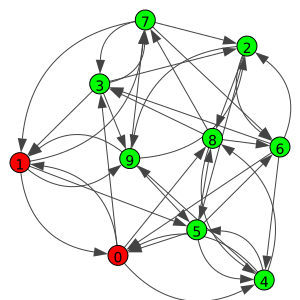

In [10]:
TestData = GraphWrapper(test_mode="knet")
TestData.get_knet(k=3)

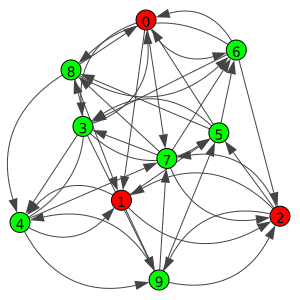

In [14]:
TestData = GraphWrapper(test_mode="knet")
TestData.get_knet(k=1)

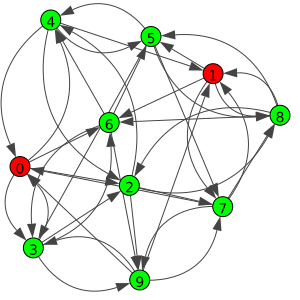

In [12]:
TestData = GraphWrapper(test_mode="knet")
TestData.get_knet(k=2)

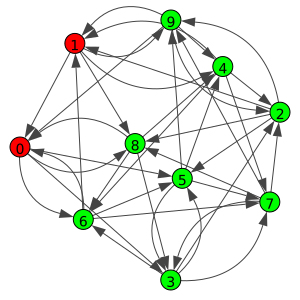

In [13]:
TestData = GraphWrapper(test_mode="knet")
TestData.get_knet(k=4)